In [159]:
import os
from IPython.display import HTML

from matplotlib import pyplot as plt, animation as animation
import numpy as np
import pandas as pd
from scipy.fft import fft, fftfreq

import pyedflib
from pyedflib import highlevel

π = np.pi

# Fourier experiment

In [365]:
# Data directory (only on Nathan's machine, just for exploring)
path = 'nathan'

# This patient is in the train set
patient_name = 'SC4111'

psg_path = os.path.join(path, f'{patient_name}E0-PSG.edf')
hyp_path = os.path.join(path, f'{patient_name}EC-Hypnogram.edf')

signals, signal_headers, header = highlevel.read_edf(psg_path)
hsignals, hsignal_headers, hheader = highlevel.read_edf(hyp_path)

In [366]:
signals[0].shape[0] // 100

79260

In [367]:
hyp = hheader['annotations']
hheader

{'technician': '',
 'recording_additional': '',
 'patientname': 'Male 26yr',
 'patient_additional': '',
 'patientcode': '',
 'equipment': '',
 'admincode': '',
 'sex': 'Male',
 'startdate': datetime.datetime(1989, 5, 1, 16, 29),
 'birthdate': '',
 'gender': 'Male',
 'annotations': [[0.0, 28050.0, 'Sleep stage W'],
  [28050.0, 60.0, 'Sleep stage 1'],
  [28110.0, 60.0, 'Sleep stage W'],
  [28170.0, 180.0, 'Sleep stage 1'],
  [28350.0, 570.0, 'Sleep stage 2'],
  [28920.0, 60.0, 'Sleep stage W'],
  [28980.0, 30.0, 'Sleep stage 1'],
  [29010.0, 30.0, 'Sleep stage W'],
  [29040.0, 60.0, 'Sleep stage 1'],
  [29100.0, 720.0, 'Sleep stage 2'],
  [29820.0, 30.0, 'Sleep stage 3'],
  [29850.0, 60.0, 'Sleep stage 2'],
  [29910.0, 30.0, 'Sleep stage 3'],
  [29940.0, 60.0, 'Sleep stage 2'],
  [30000.0, 30.0, 'Sleep stage 3'],
  [30030.0, 30.0, 'Sleep stage 2'],
  [30060.0, 30.0, 'Sleep stage 3'],
  [30090.0, 90.0, 'Sleep stage 2'],
  [30180.0, 30.0, 'Sleep stage 3'],
  [30210.0, 60.0, 'Sleep stage 2'

In [381]:
# Get the timestamps of each sleep stage annotation
# and the duration of that sleep stage
timestamps = np.array([mark[0] for mark in hyp], dtype=int)
durations = np.array([mark[1] for mark in hyp], dtype=int)

# Get the labeled stages
original_labels = \
  ['Sleep stage ?', 'Movement time', 'Sleep stage W',
   'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R']
new_labels = ['?', 'm', 'w', '1', '2', '3', '4', 'r']
label_map = { old : new for old, new in zip(original_labels, new_labels)}

stages = np.array([label_map[mark[2]] for mark in hyp])

timestamps[:10], durations[:10], stages[:10]

(array([    0, 28050, 28110, 28170, 28350, 28920, 28980, 29010, 29040,
        29100]),
 array([28050,    60,    60,   180,   570,    60,    30,    30,    60,
          720]),
 array(['w', '1', 'w', '1', '2', 'w', '1', 'w', '1', '2'], dtype='<U1'))

In [369]:
# Create a dict of dicts with the label as the key and each dict including
# the index of the corresponding data in signals
# `shs` is short for 'signal_headers'
shs = dict()
for i, d in enumerate(signal_headers):
  tmp = d
  label = tmp.pop('label')
  tmp['idx'] = i
  shs[label] = tmp

shs

{'EEG Fpz-Cz': {'dimension': 'uV',
  'sample_rate': 100.0,
  'sample_frequency': 100.0,
  'physical_max': 201.0,
  'physical_min': -204.0,
  'digital_max': 2047,
  'digital_min': -2048,
  'prefilter': 'HP:0.5Hz LP:100Hz [enhanced cassette BW]',
  'transducer': 'Ag-AgCl electrodes',
  'idx': 0},
 'EEG Pz-Oz': {'dimension': 'uV',
  'sample_rate': 100.0,
  'sample_frequency': 100.0,
  'physical_max': 175.0,
  'physical_min': -176.0,
  'digital_max': 2047,
  'digital_min': -2048,
  'prefilter': 'HP:0.5Hz LP:100Hz [enhanced cassette BW]',
  'transducer': 'Ag-AgCl electrodes',
  'idx': 1},
 'EOG horizontal': {'dimension': 'uV',
  'sample_rate': 100.0,
  'sample_frequency': 100.0,
  'physical_max': 1032.0,
  'physical_min': -1035.0,
  'digital_max': 2047,
  'digital_min': -2048,
  'prefilter': 'HP:0.5Hz LP:100Hz [enhanced cassette BW]',
  'transducer': 'Ag-AgCl electrodes',
  'idx': 2},
 'Resp oro-nasal': {'dimension': '',
  'sample_rate': 1.0,
  'sample_frequency': 1.0,
  'physical_max': 204

In [370]:
# Fourier on segments of data of this length
SECONDS = 10

info = shs['EEG Fpz-Cz']
data = signals[info['idx']]
freq = info['sample_frequency']

# The total number of samples
n = len(data)

# The number of samples per segment of SECONDS length
k = samples_per_interval = int(freq * SECONDS)

# The number of segments of SECONDS length
length = n // k

# The frequencies of the Fourier coefficients
freqs = fftfreq(k, 1/freq)[: k//2]

# Get the Fourier coefficients for each segment, saving in rows
fourier = np.full((length, k//2), -np.inf)
for i in range(length):
  subset = data[k*i : k*(i+1)]
  amps = np.real(fft(subset)[: k//2])

  fourier[i] = amps

freqs

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
       12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
       13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2,
       14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15

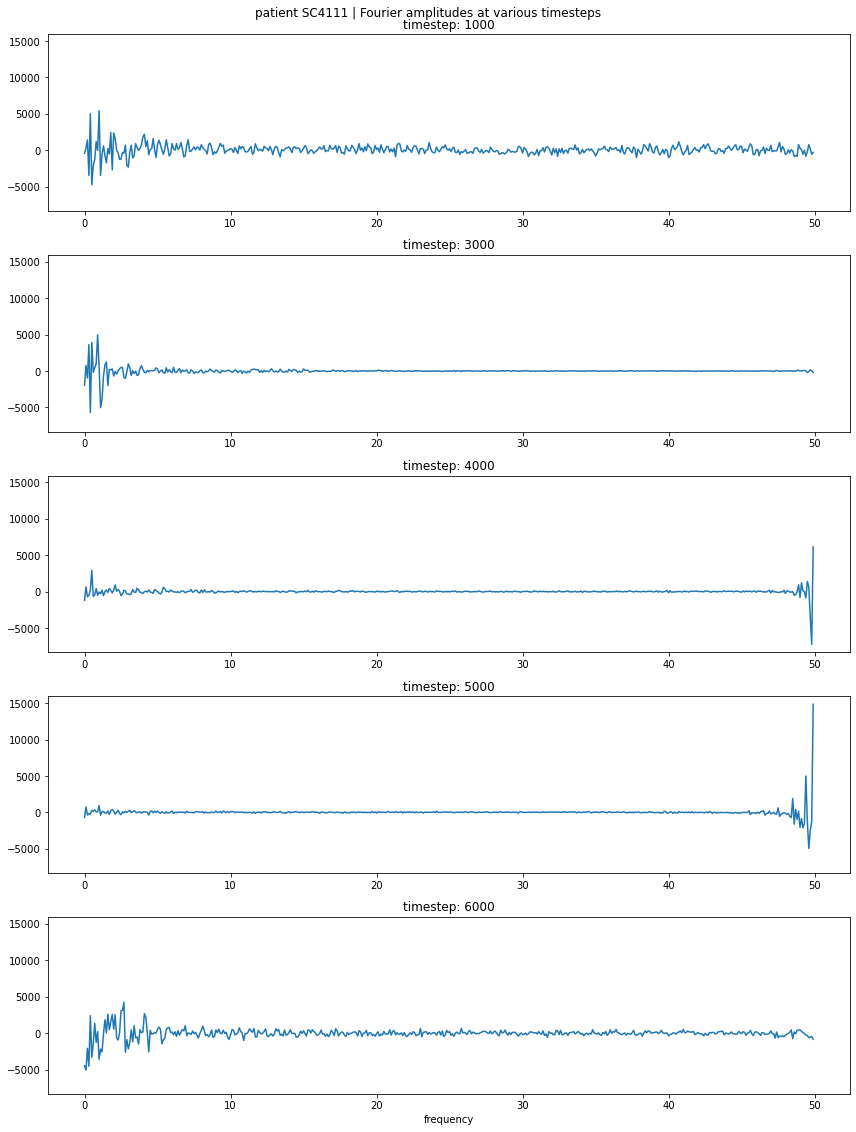

In [373]:
# Plot the Fourier coefficients from a handful of time segments
fig, axs = plt.subplots(5, 1, figsize=(12, 16), sharey=True)

idx = (1000, 3000, 4000, 5000, 6000)

for i, idx in enumerate(idx):
  ax = axs[i]
  ax.plot(freqs, fourier[idx])
  ax.set_title(f'timestep: {idx}')

axs[-1].set_xlabel('frequency')

fig.suptitle(f'patient {patient_name} | Fourier amplitudes at various timesteps')
fig.tight_layout()
fig.show()

In [374]:
animation.writer = animation.writers['ffmpeg']

In [375]:
# Number of segments, number of Fourier coefficients
T, N = fourier.shape
T, N

(7926, 500)

In [376]:
# Plot every skip'th segment
skip = 1

# The index of the lowest and highest segments to include in the animation
Tmin = 3000
Tmax = 4000

# The frequency of the highest Fourier coefficient to plot
xmax = freqs[-1]

# The indices to index into Fourier data
frames = np.arange(Tmin // skip, Tmax // skip)

# Get the indices into timestamps to find the current sleep stage
hyp_frames = np.arange(T) * SECONDS

# Get the index of the first timestamp that's less than or equal to frame
# by getting the index of the first timestamp that's greater than frame,
# then subtracting one.
hyp_idx = np.array([np.maximum(np.argmax(frame < timestamps) - 1, 0) for frame in hyp_frames])
hyp_stages = stages[hyp_idx]

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.set_xlim(0, xmax)
ax.set_ylim(fourier[Tmin:Tmax].min(), fourier[Tmin:Tmax].max())

line, = ax.plot([], [], 'r-')

def update(i):
  line.set_data(freqs, fourier[i*skip])
  ax.set_title(f'time: {i} | stage: {hyp_stages[i*skip]}')

ani = animation.FuncAnimation(fig, update, frames=frames, interval=50)

plt.close()
path = f'{patient_name}_fourier_{Tmin}-{Tmax}_annotated.mp4'
ani.save(path)

# Explore data

In [327]:
data_path = 'sleep-cassette-aggregate.npz'

data = np.load(data_path)

In [328]:
data.files

['labels',
 'SC4711',
 'SC4712',
 'SC4401',
 'SC4402',
 'SC4661',
 'SC4662',
 'SC4371',
 'SC4372',
 'SC4231',
 'SC4232',
 'SC4571',
 'SC4572',
 'SC4001',
 'SC4002',
 'SC4431',
 'SC4432',
 'SC4511',
 'SC4512',
 'SC4561',
 'SC4562',
 'SC4141',
 'SC4142',
 'SC4731',
 'SC4732',
 'SC4161',
 'SC4162',
 'SC4771',
 'SC4772',
 'SC4501',
 'SC4502',
 'SC4491',
 'SC4492',
 'SC4021',
 'SC4022',
 'SC4271',
 'SC4272',
 'SC4081',
 'SC4082',
 'SC4481',
 'SC4482',
 'SC4531',
 'SC4532',
 'SC4101',
 'SC4102',
 'SC4041',
 'SC4042',
 'SC4541',
 'SC4542',
 'SC4111',
 'SC4112',
 'SC4421',
 'SC4422',
 'SC4121',
 'SC4122',
 'SC4281',
 'SC4282',
 'SC4581',
 'SC4582',
 'SC4741',
 'SC4742',
 'SC4641',
 'SC4642',
 'SC4191',
 'SC4192',
 'SC4591',
 'SC4592',
 'SC4291',
 'SC4292',
 'SC4381',
 'SC4382',
 'SC4611',
 'SC4612',
 'SC4351',
 'SC4352',
 'SC4331',
 'SC4332',
 'SC4411',
 'SC4412',
 'SC4051',
 'SC4052',
 'SC4451',
 'SC4452',
 'SC4551',
 'SC4552',
 'SC4071',
 'SC4072',
 'SC4761',
 'SC4762',
 'SC4522',
 'SC4171',

In [329]:
train_patients = data['validate_patients']
train_patients

array(['SC4251', 'SC4252', 'SC4131', 'SC4321', 'SC4322', 'SC4481',
       'SC4482', 'SC4151', 'SC4152', 'SC4741', 'SC4742', 'SC4311',
       'SC4312', 'SC4201', 'SC4202', 'SC4591', 'SC4592', 'SC4571',
       'SC4572', 'SC4771', 'SC4772', 'SC4001', 'SC4002', 'SC4362',
       'SC4101', 'SC4102', 'SC4821', 'SC4822', 'SC4031', 'SC4032'],
      dtype='<U6')

In [330]:
labels = data['labels']
labels

array(['EEG FPZ-CZ-freq0', 'EEG FPZ-CZ-freq1', 'EEG FPZ-CZ-freq2',
       'EEG FPZ-CZ-freq3', 'EEG FPZ-CZ-freq4', 'EEG PZ-OZ-freq0',
       'EEG PZ-OZ-freq1', 'EEG PZ-OZ-freq2', 'EEG PZ-OZ-freq3',
       'EEG PZ-OZ-freq4', 'EOG HORIZONTAL-freq0', 'EOG HORIZONTAL-freq1',
       'EOG HORIZONTAL-freq2', 'EOG HORIZONTAL-freq3',
       'EOG HORIZONTAL-freq4', 'EMG SUBMENTAL-freq0',
       'EMG SUBMENTAL-freq1', 'EMG SUBMENTAL-freq2',
       'EMG SUBMENTAL-freq3', 'EMG SUBMENTAL-freq4',
       'RESP ORO-NASAL-mean', 'TEMP RECTAL-mean', '_HYPNO-mode'],
      dtype='<U20')

## Patient SC4111 in train data

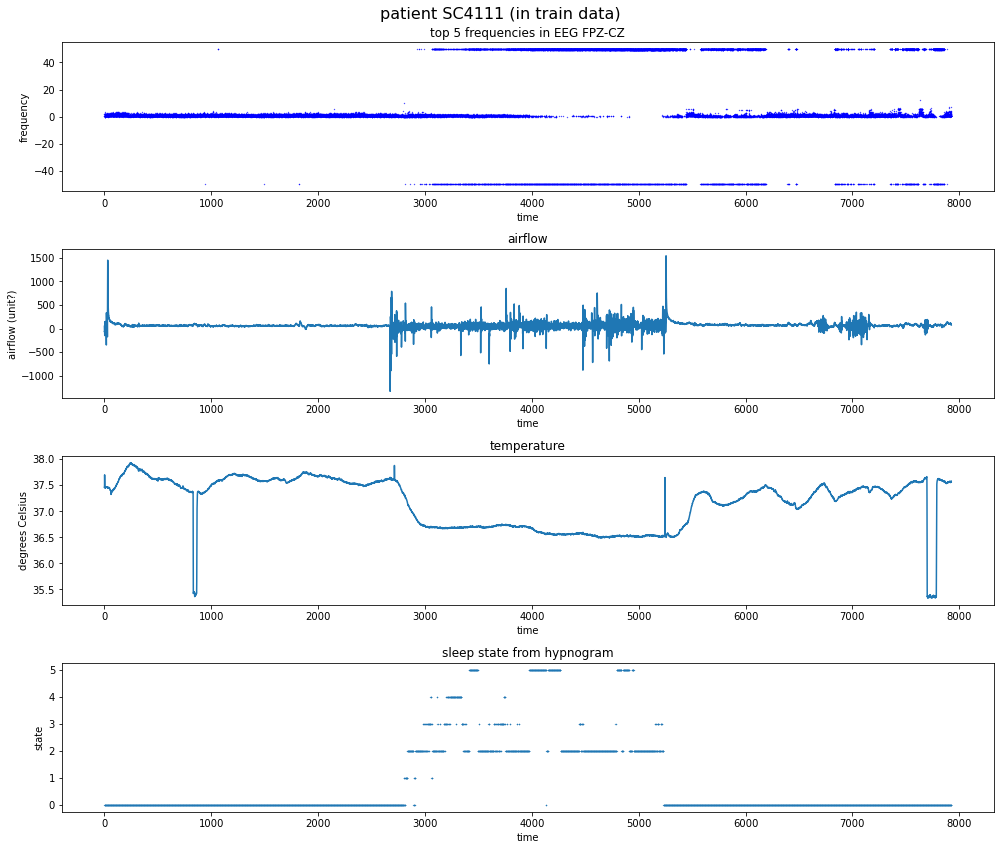

In [342]:
patient_name = 'SC4111'
patient = data[patient_name]

# Number of time steps, number of columns
T, C = patient.shape

fig, axs = plt.subplots(4, 1, figsize=(14, 12))

ax = axs[0]
ticks = range(T)
ax.scatter(ticks, patient[:, 0], s=0.1, color='blue')
ax.scatter(ticks, patient[:, 1], s=0.1, color='blue')
ax.scatter(ticks, patient[:, 2], s=0.1, color='blue')
ax.scatter(ticks, patient[:, 3], s=0.1, color='blue')
ax.scatter(ticks, patient[:, 4], s=0.1, color='blue')
ax.set_title(f'top 5 frequencies in {labels[0][:-6]}')
ax.set_ylabel('frequency')
ax.set_xlabel('time')

ax = axs[1]
ax.plot(patient[:, 20])
ax.set_title('airflow')
ax.set_ylabel('airflow (unit?)')
ax.set_xlabel('time')

ax = axs[2]
ax.plot(patient[:, 21])
ax.set_title('temperature')
ax.set_ylabel('degrees Celsius')
ax.set_xlabel('time')

ax = axs[3]
ax.scatter(range(T), patient[:, -1], s=0.1)
ax.set_title('sleep state from hypnogram')
ax.set_ylabel('state')
ax.set_xlabel('time')

fig.suptitle(f'patient {patient_name} (in train data)', fontsize=16)
fig.tight_layout()
fig.show()

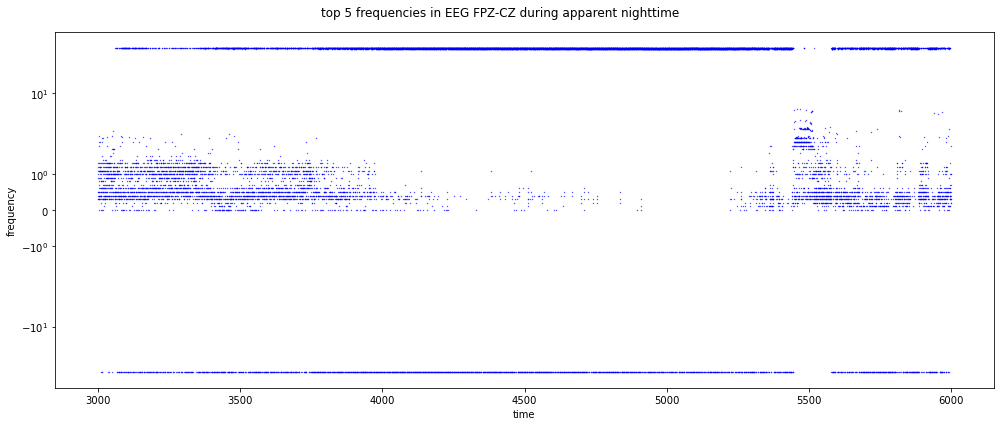

In [343]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

start, stop = 3000, 6000
slice = patient[start:stop]
Tslice = slice.shape[0]
ticks = range(start, start + Tslice)

# Scatterplot the values in the first channel (all of the top 5 frequencies)
ax.scatter(ticks, slice[:, 0], s=0.1, color='blue')
ax.scatter(ticks, slice[:, 1], s=0.1, color='blue')
ax.scatter(ticks, slice[:, 2], s=0.1, color='blue')
ax.scatter(ticks, slice[:, 3], s=0.1, color='blue')
ax.scatter(ticks, slice[:, 4], s=0.1, color='blue')

ax.set_yscale('symlog')

ax.set_xlabel('time')
ax.set_ylabel('frequency')

fig.suptitle(f'top 5 frequencies in {labels[0][:-6]} during apparent nighttime')
fig.tight_layout()
fig.show()

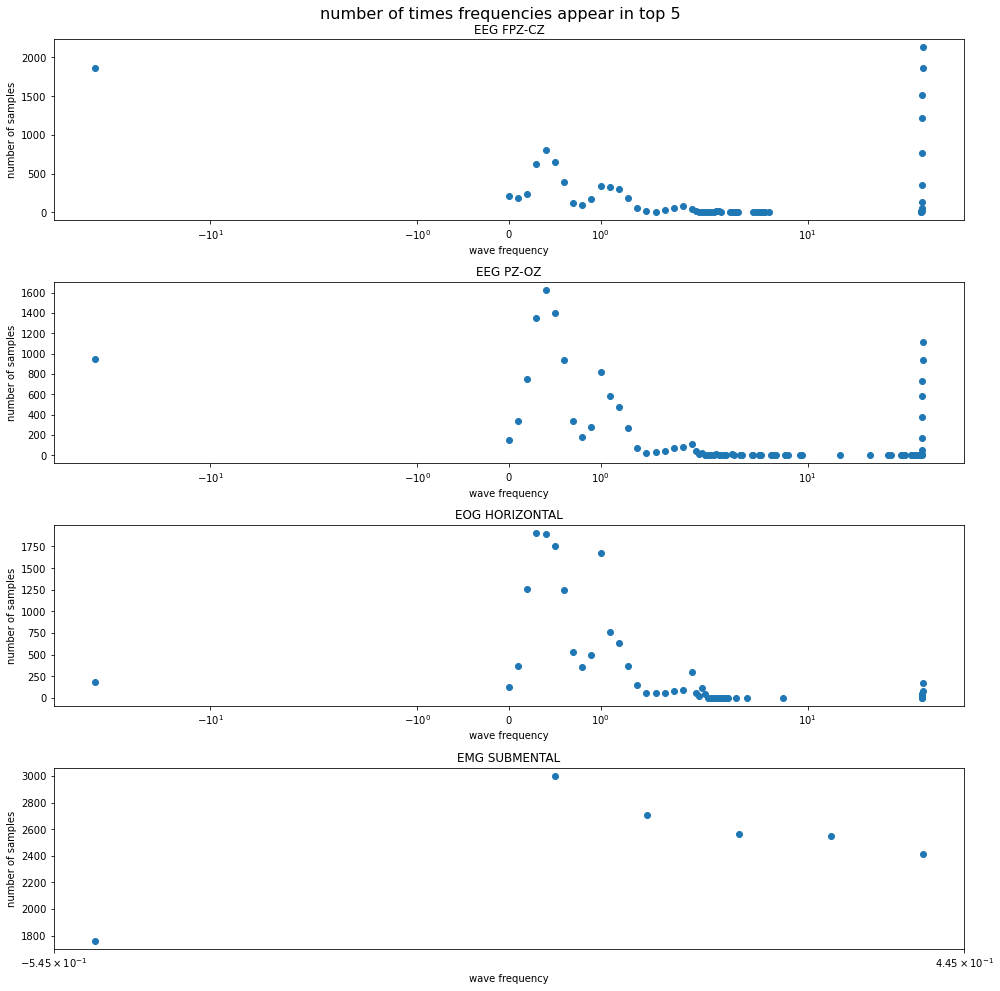

In [344]:
fig, axs = plt.subplots(4, 1, figsize=(14, 14))

for i, ax in enumerate(axs):
  # Get the 5 columns corresponding to the current channel
  df = pd.DataFrame(np.ravel(slice[:, 5*i : 5*(i+1)]))
  
  # Get the value counts for each frequency
  vcs = df.value_counts()
  idx = vcs.index.get_level_values(0).to_numpy()
  vals = vcs.to_numpy()
  
  ax.scatter(idx, vals)

  ax.set_title(labels[5*i][:-6])
  ax.set_xscale('symlog')
  ax.set_xlabel('wave frequency')
  ax.set_ylabel('number of samples')

fig.suptitle('number of times frequencies appear in top 5', fontsize=16)
fig.tight_layout()
fig.show()

In [269]:
slice[:20, 0], slice[:20, 16]

(array([  0.4,   1. ,   0.9,   1.1,   0.5,   0.5,   1.3,   0.6,   1. ,
          1. ,   0.3,   0. ,   0.4, -50. ,   0.5,   1.1,   0.3,   1.2,
          0.4,   0.6]),
 array([ 0.4, -0.5,  0.2, -0.5,  0.3,  0.1,  0.2,  0.3,  0.4,  0.4,  0.2,
         0.1,  0.3,  0.1,  0.4,  0.2,  0.3,  0.4,  0.3,  0.1]))

## Patient SC4001 in val data

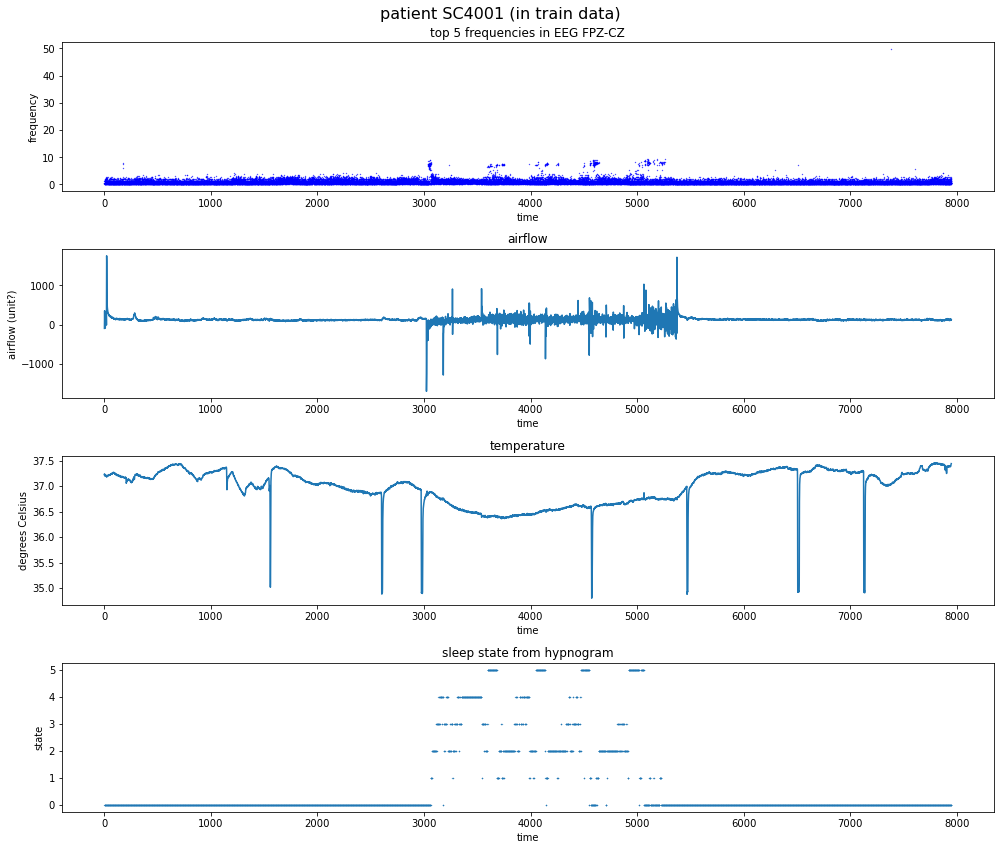

In [345]:
patient_name = 'SC4001'
patient = data[patient_name]

# Number of time steps, number of columns
T, C = patient.shape

fig, axs = plt.subplots(4, 1, figsize=(14, 12))

ax = axs[0]
ticks = range(T)
ax.scatter(ticks, patient[:, 0], s=0.1, color='blue')
ax.scatter(ticks, patient[:, 1], s=0.1, color='blue')
ax.scatter(ticks, patient[:, 2], s=0.1, color='blue')
ax.scatter(ticks, patient[:, 3], s=0.1, color='blue')
ax.scatter(ticks, patient[:, 4], s=0.1, color='blue')
ax.set_title(f'top 5 frequencies in {labels[0][:-6]}')
ax.set_ylabel('frequency')
ax.set_xlabel('time')

ax = axs[1]
ax.plot(patient[:, 20])
ax.set_title('airflow')
ax.set_ylabel('airflow (unit?)')
ax.set_xlabel('time')

ax = axs[2]
ax.plot(patient[:, 21])
ax.set_title('temperature')
ax.set_ylabel('degrees Celsius')
ax.set_xlabel('time')

ax = axs[3]
ax.scatter(range(T), patient[:, -1], s=0.1)
ax.set_title('sleep state from hypnogram')
ax.set_ylabel('state')
ax.set_xlabel('time')

fig.suptitle(f'patient {patient_name} (in train data)', fontsize=16)
fig.tight_layout()
fig.show()

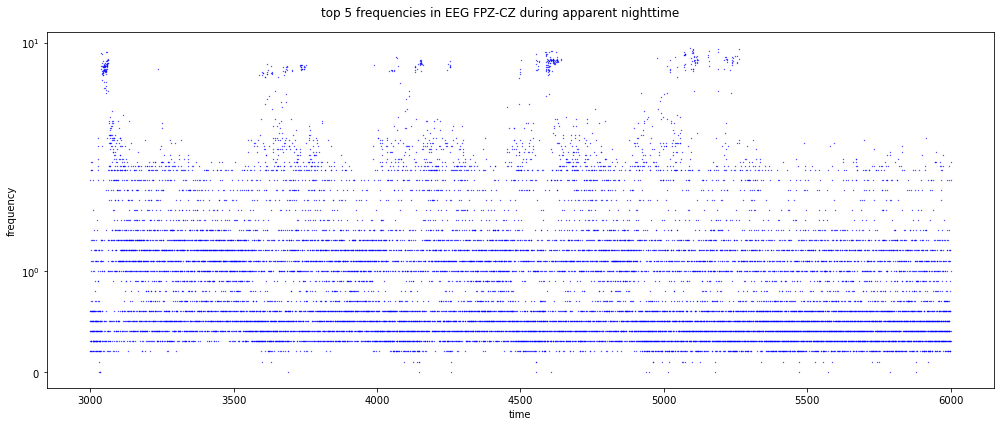

In [346]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

start, stop = 3000, 6000
slice = patient[start:stop]
Tslice = slice.shape[0]
ticks = range(start, start + Tslice)

# Scatterplot the values in the first channel (all of the top 5 frequencies)
ax.scatter(ticks, slice[:, 0], s=0.1, color='blue')
ax.scatter(ticks, slice[:, 1], s=0.1, color='blue')
ax.scatter(ticks, slice[:, 2], s=0.1, color='blue')
ax.scatter(ticks, slice[:, 3], s=0.1, color='blue')
ax.scatter(ticks, slice[:, 4], s=0.1, color='blue')

ax.set_yscale('symlog')

ax.set_xlabel('time')
ax.set_ylabel('frequency')

fig.suptitle(f'top 5 frequencies in {labels[0][:-6]} during apparent nighttime')
fig.tight_layout()
fig.show()

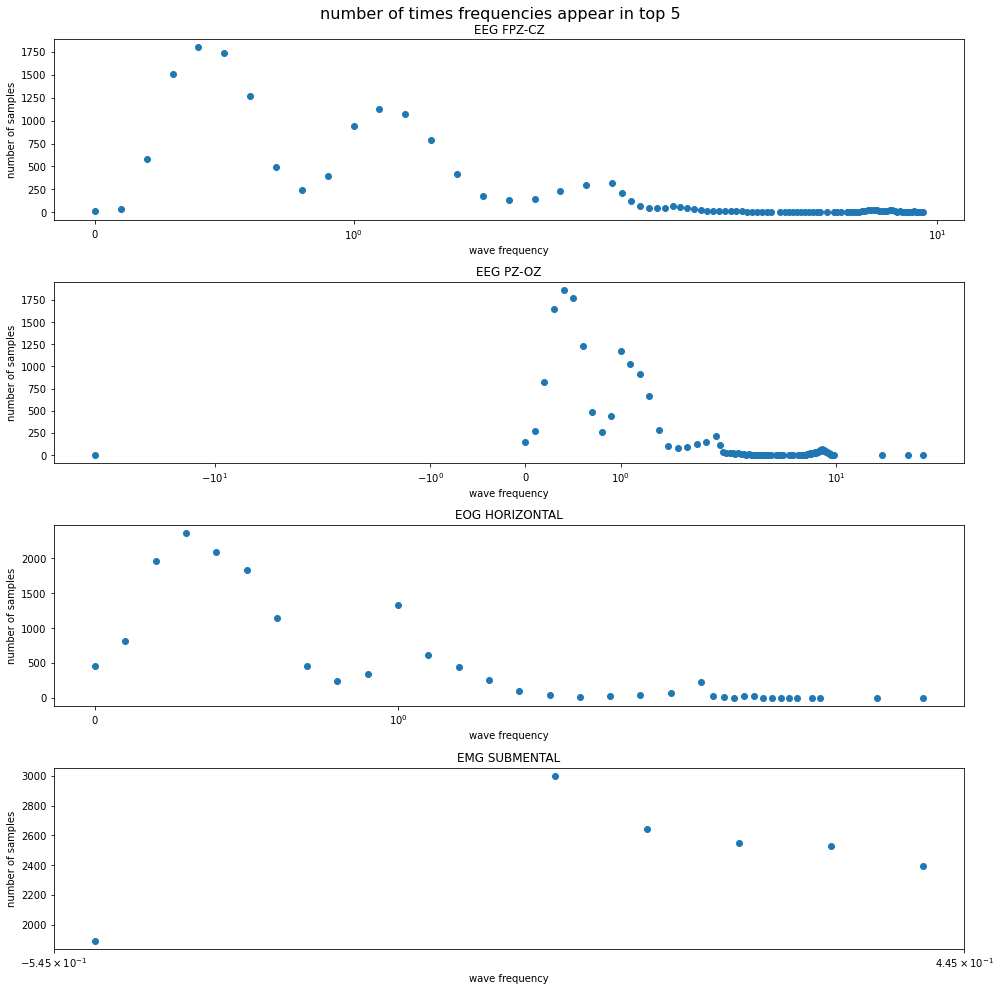

In [347]:
fig, axs = plt.subplots(4, 1, figsize=(14, 14))

for i, ax in enumerate(axs):
  # Get the 5 columns corresponding to the current channel
  df = pd.DataFrame(np.ravel(slice[:, 5*i : 5*(i+1)]))
  
  # Get the value counts for each frequency
  vcs = df.value_counts()
  idx = vcs.index.get_level_values(0).to_numpy()
  vals = vcs.to_numpy()
  
  ax.scatter(idx, vals)

  ax.set_title(labels[5*i][:-6])
  ax.set_xscale('symlog')
  ax.set_xlabel('wave frequency')
  ax.set_ylabel('number of samples')

fig.suptitle('number of times frequencies appear in top 5', fontsize=16)
fig.tight_layout()
fig.show()

In [348]:
slice[:20, 0], slice[:20, 16]

(array([0.4, 0.5, 0.3, 0.5, 0.4, 0.4, 0.4, 0.5, 0.5, 0.4, 0.3, 0.6, 0.5,
        0.4, 0.5, 0.3, 0.5, 0.3, 0.5, 0.4]),
 array([ 0.1,  0.2,  0.2,  0.3,  0.1, -0.5,  0.1,  0.1, -0.5,  0.2,  0.1,
         0.4,  0.3,  0.3,  0.4,  0.2,  0.1, -0.5,  0.2,  0.4]))

# Fourier exploration

1.0
[0. 1. 2. 3. 4.]


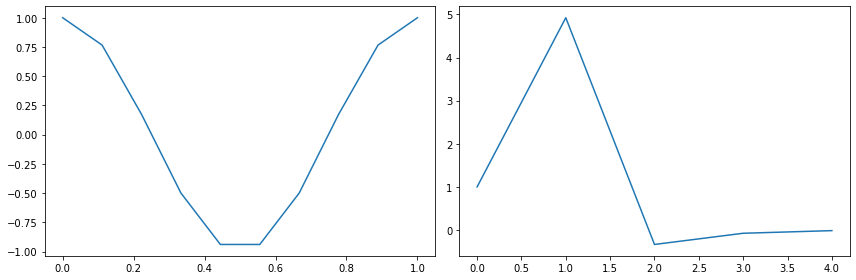

In [110]:
period = np.array([1])
f = lambda t: np.sum(np.cos(2*π/period[:, np.newaxis] * t), axis=0)

t0, tf = 0, 1
tn = 10
tls = np.linspace(t0, tf, tn)

sample_freq = (tf - t0)/tn

samples = f(tls)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
ax.plot(tls, samples)

ax = axs[1]
amps = np.real(fft(samples))
freqs = fftfreq(tn, sample_freq)

ax.plot(freqs[:tn//2], amps[:tn//2])

fig.tight_layout()
fig.show()

i = 6
np.stack((amps[:i], freqs[:i]))

print(1 / freqs[amps.argmax()])

# So using fftfreq (correctly) gets us the frequencies corresponding to the fft amplitutde outputs.
# TODO: Check the output of fftfreq on the 100 Hz and 1 Hz channels, over the 10-second (?) intervals
print(freqs[:len(freqs)//2])